## Text preprocessing

In [38]:
import pandas as pd

In [39]:
df_train = pd.read_csv("./data/train.txt", sep=";", 	header = None)
df_validation = pd.read_csv("./data/validation.txt", sep=";", header = None)
df_test = pd.read_csv("./data/test.txt", sep=";", header = None)

df_train.columns = ['text', 'label']
df_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [40]:

df_validation.columns = ['text', 'label']
df_test.columns = ['text', 'label']

In [41]:
print(df_train.columns)
print(df_validation.columns)
print(df_test.columns)


Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [43]:
df_train.label.unique()
# we have 6 sentiments

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

### Preprocessing the dataset

In [44]:

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess (docs):
    #tokens
    tokens =  [word_tokenize(doc.lower()) for doc in docs]
    #stop_words
    tokens = [ [word for word in doc  if word.isalnum() and word not in stop_words]  for doc in tokens]
    #lemmatazation
    tokens =  [[lemmatizer.lemmatize(w, pos='v') for w in doc] for doc in tokens]
    return [" ".join(doc) for doc in tokens]



In [45]:
train_texts = preprocess(df_train['text'].tolist())
val_texts   = preprocess(df_validation['text'].tolist())
test_texts  = preprocess(df_test['text'].tolist())



In [46]:
#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train = tfidf.fit_transform(train_texts)
X_val   = tfidf.transform(val_texts)
X_test  = tfidf.transform(test_texts)


In [47]:
# encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(df_train['label'])
y_val   = le.transform(df_validation['label'])
y_test  = le.transform(df_test['label'])


### Creating Baseline model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])


C:\Users\yazid\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │     6,498,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,502,918 (24.81 MB)

 Trainable params: 6,502,918 (24.81 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2,
    batch_size=32
)


Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.6583 - loss: 0.9892 - val_accuracy: 0.8440 - val_loss: 0.4289
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9706 - loss: 0.1089 - val_accuracy: 0.8770 - val_loss: 0.3705


In [51]:
model.evaluate(X_test, y_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8770 - loss: 0.3705


[0.37051406502723694, 0.8769999742507935]

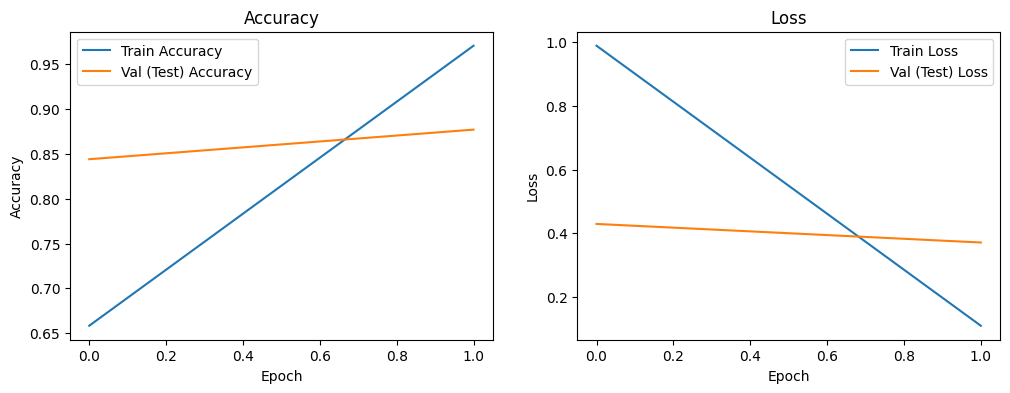

In [52]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val (Test) Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val (Test) Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:

val_loss_fcnn, val_acc_fcnn = model.evaluate(X_val, y_val, verbose=0)
print(f"FCNN Validation Accuracy: {val_acc_fcnn*100:.2f}%")

FCNN Validation Accuracy: 87.45%


## Summary of FCNN results

- Train accuracy reacher 99 % with only 2 epochs but validation (test) accuracy plateaus at ~87%.
- Train loss drops sharply, validation loss flattens then slightly rises.
- model memorizes training data but generalizes decently (final ~87.5%).
- i've tried many parameters like 
denses (Two hidden layers of 64 units: Provides enough capacity to learn complex patterns in TF-IDF)...
 epochs (only 2 was good to get best score)...
  batch size (32 was best compared to 16 and 8), i found this is best parameters for this data.

# LSTM

In [ ]:
# 1. Tokenizer & Padding 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)  # Fit on preprocessed train texts


In [59]:


# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [ ]:

#  Class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.2351397251814111, 1: 1.3766993632765445, 2: 0.49732686808404825, 3: 2.044989775051125, 4: 0.5715102157451064, 5: 4.662004662004662}


### Build BiLSTM model

In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 128

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\yazid\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:



model.summary()

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=3,  
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (64, 100, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (64, 256)              │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (64, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (64, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (64, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,680,020 (17.85 MB)

 Trainable params: 1,560,006 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,120,014 (11.90 MB)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - accuracy: 0.5674 - loss: 1.0643 - val_accuracy: 0.8460 - val_loss: 0.5276
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 449ms/step - accuracy: 0.8783 - loss: 0.3906 - val_accuracy: 0.8645 - val_loss: 0.4451
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 431ms/step - accuracy: 0.9118 - loss: 0.2654 - val_accuracy: 0.8810 - val_loss: 0.3870


In [ ]:


#  test evaluation
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nBiLSTM Test Accuracy: {test_acc*100:.2f}%")


BiLSTM Test Accuracy: 88.10%


In [66]:
# Evaluate on Validation set
#  Preprocess and prepare validation data (same as train/test)
val_texts = preprocess(df_validation['text'].tolist())
y_val = le.transform(df_validation['label'])  # Same LabelEncoder

# Tokenize and pad validation
val_seq = tokenizer.texts_to_sequences(val_texts)
X_val_pad = pad_sequences(val_seq, maxlen=max_len, padding='post')




In [67]:
#  Evaluate on Validation set
val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
print(f"BiLSTM Validation Accuracy: {val_acc*100:.2f}%")


BiLSTM Validation Accuracy: 89.85%


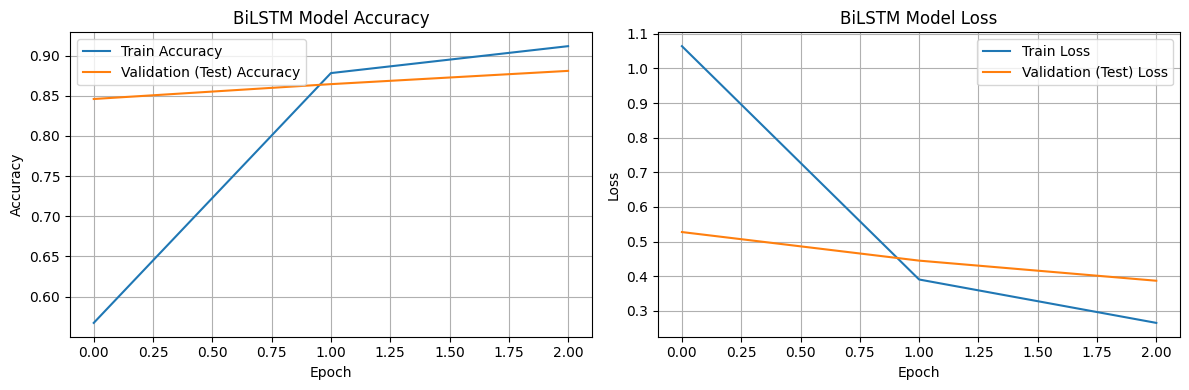

In [69]:

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Train accuracy rises smoothly to ~90%, validation follows very closely (~89%). Both train and validation loss decrease steadily together
- BiLSTM plot shows a healthier learning


## Conclusion

* How to Proceed with Another Text Classification Task

- Quick baseline: TF-IDF + Logistic Regression or small MLP (fast check).
- Search Hugging Face: Look for existing fine-tuned model on similar task/domain.
- Default choice: Fine-tune a small pretrained Transformer (DistilBERT, MobileBERT) 
- Handle imbalance: Use class weights or balanced sampling.
- Evaluate properly: Hold out true validation until end
- Only use classics/RNNs if no GPU or need full interpretability.